<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/pytorch/blob/main/feedforward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What you will learn

1. Dataset transforms 
1. Batch data and stochastic gradient descent
1. Using Pytorch predefined layers 
1. Multilayer full connected networks
1. ReLU activation function
1. Using the GPU


In [1]:
import torch
import torchvision as vision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

## The data

The data in this notebook is MNIST. It is a collection of handwritten digits along with their corresponding labels. Our task is to build an network that reconigzes handwritten digit.
As we did in the previous notebook, we need to perform some transformation on the dataset. But rather than perform it manually as we did before we will be using transform classes defined in ```torchvision.transforms```

In [2]:
mnist_train=vision.datasets.MNIST(".",download=True,train=True)
mnist_test=vision.datasets.MNIST(".",download=True,train=False)

In [ ]:
img,label=mnist_train[0]
print("img type is {} and label type is {} ".format(type(img),type(label)))

### Inspecting the data


In [ ]:
import matplotlib.pyplot as plt
fig=plt.figure()
fig.tight_layout()
plt.subplots_adjust( wspace=1, hspace=1)
for i in range(20):
            img,label=mnist_train[i]
            t=fig.add_subplot(4,5,i+1)
            # set the title of the image equal to its label
            t.set_title(str(label))
            t.axes.get_xaxis().set_visible(False)
            t.axes.get_yaxis().set_visible(False)
            plt.imshow(img,cmap='gray_r')

### Transforming the data
As we saw the imgages are in PIL format so we need to transform them to Pytorch tensors. Also, it is good practice to normalize the data. Now, instead of modifying the data manually as we did previously, we can use transforms from ```torchvision.transforms``` package. Furthermore, the transformations can be **composed** using the ```torchvision.transforms.Compose```

In [5]:
#since the input has 1 channel we need 1 value for mean and 1 for stdev
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.5,0.5)])
mnist_train=vision.datasets.MNIST(".",download=False,train=True,transform=transform)
mnist_test=vision.datasets.MNIST(".",download=False,train=False,transform=transform)


## Batches and Stochastic Gradient Descent

- Previously we have use the **entire** dataset to compute the gradients. 
- When the model is complicated and dataset is large this becomes an expensive operation. 
- By contrast, (mini-batch) gradient descent _approximates_ the gradient by using a small sample of the data, called batches.
- When the batch is size is 1 it is called stochastic gradient descent.
- For example, if the size of the dataset is $n$ and the batch size is $b$ then SGD will perform $n/b$ iterations instead of a single one, which leads to faster convergence. 
- To avoid overfitting, the batches are selected randomly in each epoch

In [6]:
train_loader=torch.utils.data.DataLoader(mnist_train,batch_size=64,shuffle=True)
test_loader=torch.utils.data.DataLoader(mnist_test,batch_size=64,shuffle=False)

## Multilayer fully connected networks

A multilayer fully connected network is a generalization of the single-layer single-node logistic regression we saw in the previous notebook. It looks like the figure below (borrowed from https://zhu45.org/)

In the figure below there are 2 "computation" layers and a total of 4 layers if
we include the input and output. The main idea is that at every layer the value at each node depends on all nodes in the preceeding layer.
In Pytorch such layers are called ```Linear```




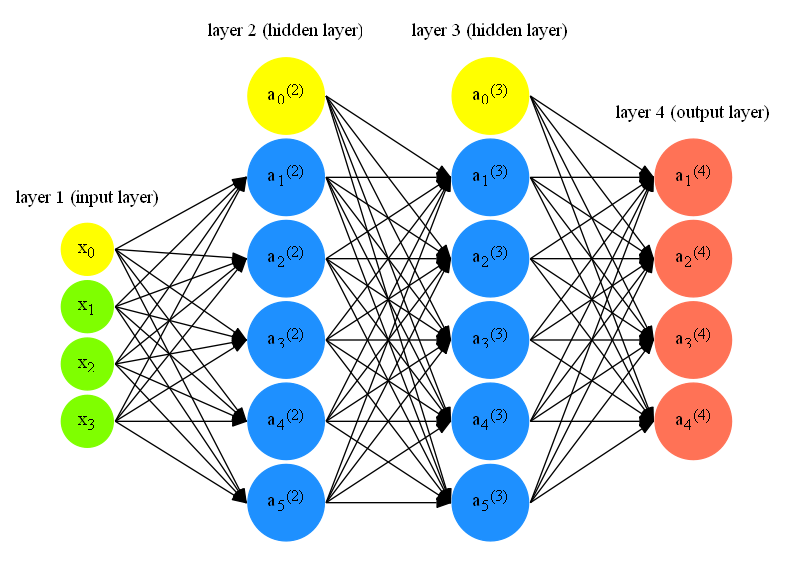

## Pytorch model

The model we use in this notebook is a (not very) deep one, consisting of 3 **fully connected** layers. Also, instead of the sigmoid we use the ReLU activation function.

In [7]:
input_size=28*28
output_size=10
hidden_size1=128
hidden_size2=64
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.flatten=nn.Flatten()
    self.layer1=nn.Linear(input_size,hidden_size1)
    self.layer2=nn.Linear(hidden_size1,hidden_size2)
    self.layer3=nn.Linear(hidden_size2,output_size)
    self.relu=nn.ReLU()
  def forward(self,x):
    x=self.flatten(x)
    x=self.layer1(x)
    x=self.relu(x)
    x=self.layer2(x)
    x=self.relu(x)
    x=self.layer3(x)

    return x



In [ ]:
model=Net()
print(model)

### What is ReLU?


In [ ]:
def ReLU(x):
    if x >=0:
        return x
    return 0
def LReLU(x):
    if x>=0:
        return x
    return 0.01*x
x=[i for i in range(-10,10)]
u=[ReLU(z) for z in x]
v=[LReLU(z) for z in x]
plt.ylim(-0.1,2)
plt.plot(x,u,label='ReLU')
plt.plot(x,v,label='LReLU')
plt.legend()

## Why ReLU?
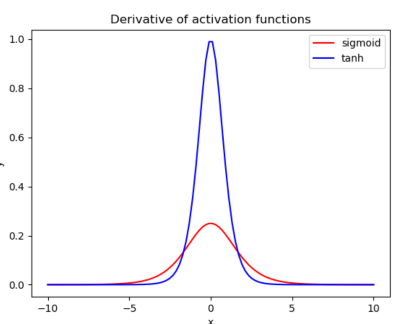


## Learning loop

This is the "standard" learning loop with a few changes. 
1. Since we are using batches, an epoch finishes when all the batches in the dataset are processed.
1. We perform the computation on the GPU by using the ```.cuda()``` tensor method
1. Since we have 10 classes we use the ```CrossEntropyLoss``` instead of ```BCELoss```



**Note** the ```CrossEntropyLoss``` computes the _softmax_ of the output of the model before computing the loss. This is why the last layer of our model does not use _softmax_

In [ ]:
model=model.cuda()
import torch.optim as optim
epochs=3 # 3 epochs to save time
optimizer=optim.SGD(model.parameters(),lr=0.01)
loss_fn=nn.CrossEntropyLoss()
running_loss=0.0
for epoch in range(epochs):
  for i,data in enumerate(train_loader):
    optimizer.zero_grad()
    img,label=data
    img,label=img.cuda(),label.cuda()
  
    output=model(img)
    loss=loss_fn(output,label)
  
    loss.backward()
    optimizer.step()
    running_loss=0.99*running_loss+0.01*loss.item()
  print("loss {:.4f}".format(running_loss))


In [11]:
total=0
correct=0
for data in test_loader:
  imgs,labels=data
  imgs=imgs.cuda()
  labels=labels.cuda()
  outputs=model(imgs)
  # the second return value is the index of the max i.e. argmax
  _,predicted=torch.max(outputs.data,1)
  total+=labels.size(0)
  correct+=(predicted==labels).sum()


In [ ]:
print("accuracy of prediction {:.3f}".format((correct/total).item()))